In [89]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime
from utils_tensorflow import *

mpl.rcParams['figure.figsize'] = (16, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ticker = 'AAPL'
HISTORY_START_DATE = '2012-01-01'

df = si.get_data(ticker)
df = df[df.index >= HISTORY_START_DATE]
df['adjclose'].dropna(inplace=True)

In [3]:
df.tail()

,open,high,low,close,adjclose,volume,ticker
2020-05-21,318.660004,320.890015,315.869995,316.850006,316.850006,25672200.0,AAPL
2020-05-22,315.769989,319.230011,315.350006,318.890015,318.890015,20450800.0,AAPL
2020-05-26,323.500000,324.239990,316.500000,316.730011,316.730011,31380500.0,AAPL
2020-05-27,316.140015,318.709991,313.089996,318.109985,318.109985,28236300.0,AAPL
2020-05-28,316.769989,323.440002,315.630005,318.250000,318.250000,33390200.0,AAPL


In [4]:
df.shape

(2114, 7)

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018FF0E04630>],
      dtype=object)

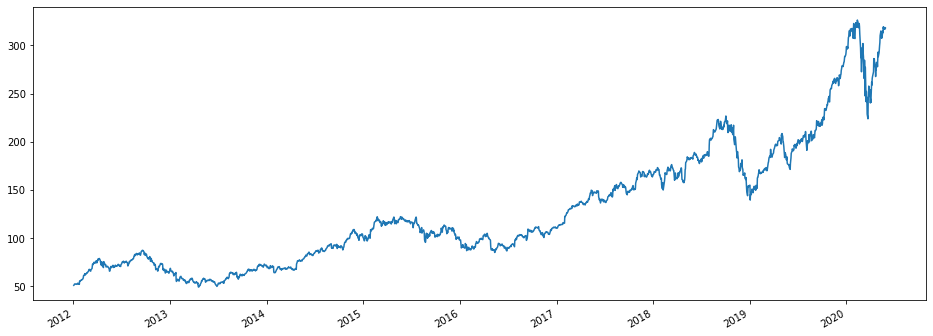

In [5]:
df['adjclose'].plot(subplots=True)

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [6]:
features_considered = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

In [7]:
features = df[df['open'].isna()==False][features_considered]
features = features[features.index > '2012-01-01']
features.head()

,open,high,low,close,adjclose,volume
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.857235,75555200.0
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.130558,65005500.0
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.698215,67817400.0
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.238651,79573200.0
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.155792,98506100.0


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018FF0C040F0>,
      dtype=object)

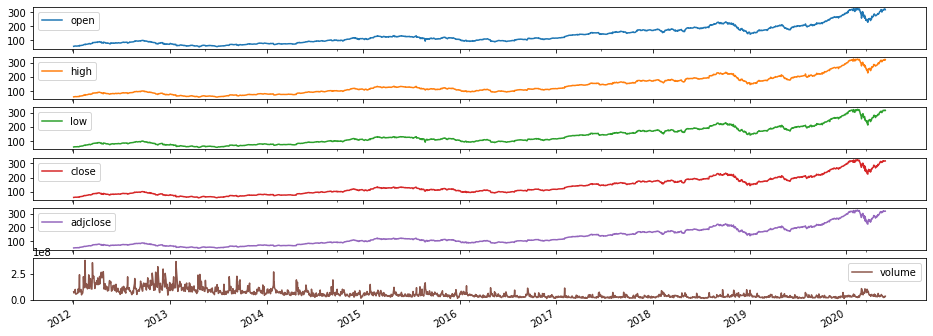

In [8]:
features.plot(subplots=True)

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [9]:
data_scaled = features.copy()

TRAIN_SPLIT = int(df.shape[0] * 0.75)
print(f"TRAIN_SPLIT: {TRAIN_SPLIT}, TEST SPLIT: {df.shape[0] - TRAIN_SPLIT}")

column_scaler = {}
# scale the data (prices) from 0 to 1
for column in data_scaled.columns:
    
    column_values = data_scaled[column].values.reshape(-1, 1)
    # Fit only on training data
    scaler = MinMaxScaler()
    scaler.fit(column_values[:TRAIN_SPLIT])
    data_scaled[column] = scaler.transform(column_values)
    column_scaler[column] = scaler

data_scaled.tail()

TRAIN_SPLIT: 1585, TEST SPLIT: 529


,open,high,low,close,adjclose,volume
2020-05-21,2.070021,2.086823,2.083583,2.073056,2.105747,0.038888
2020-05-22,2.047295,2.073692,2.079430,2.089256,2.121786,0.024585
2020-05-26,2.108082,2.113323,2.088615,2.072104,2.104804,0.054525
2020-05-27,2.050205,2.069578,2.061378,2.083062,2.115653,0.045912
2020-05-28,2.055159,2.106995,2.081666,2.084174,2.116754,0.060030


### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [16]:
dataset.shape[0]

2114

In [ ]:
TEST_SPLIT = dataset.shape

In [58]:
target_variable = 'adjclose'
target_var_index = data_scaled.columns.tolist().index(target_variable)

target = data_scaled[target_variable].values
dataset = data_scaled.values

past_history = 30
future_target = 7
BATCH_SIZE = 64
BUFFER_SIZE = 1000

TEST_SPLIT = dataset.shape[0] - 1 - past_history

train_data = prepare_batches(dataset, target,
                             0, TRAIN_SPLIT,
                             past_history, future_target)
val_data = prepare_batches(dataset, target,
                           TRAIN_SPLIT, TEST_SPLIT,
                           past_history, future_target)

test_data = prepare_test_batch(dataset, TEST_SPLIT, None,  past_history)

In [85]:
test_dates = prepare_dates(dates, TEST_SPLIT, 2108, 
                          past_history, future_target)

2106
2107


Let's check out a sample data-point.

In [78]:
dates = data_scaled[data_scaled.index > HISTORY_START_DATE].index
dates = np.array(dates.date, 'str')

train_dates = prepare_dates(dates, 0, TRAIN_SPLIT, 
                            past_history, future_target)

val_dates = prepare_dates(dates, TRAIN_SPLIT, TEST_SPLIT, 
                          past_history, future_target)

test_dates = prepare_dates(dates, TEST_SPLIT, 2108, 
                          past_history, future_target)

In [19]:
# print ('Single window of past history : {}'.format(x_train_multi[0].shape))
# print ('Target to predict : {}'.format(y_train_multi[0].shape))

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

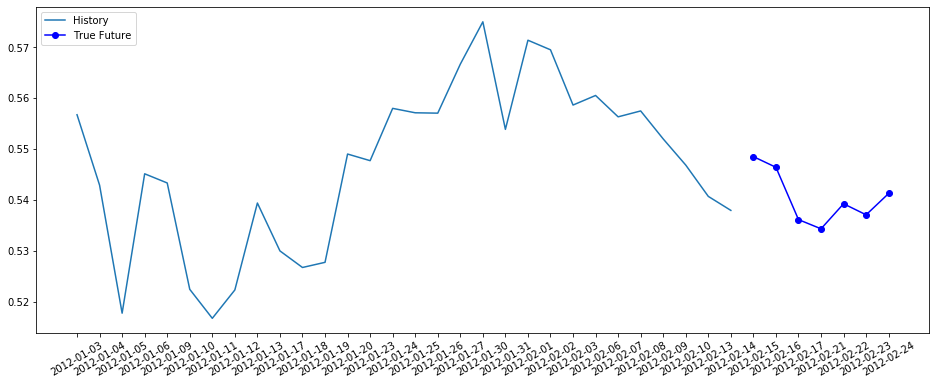

In [20]:
for xy, date in zip(train_data.take(1), train_dates.take(1)):
    
    x, y = xy
#     print(x[0].numpy())
    x_dates, y_dates = date
    history = np.array(x[0])[:, target_var_index]
    true_future = np.array(y[0])
#     print(history)
    
    multi_step_plot_dates(x_dates[0].numpy(), history, y_dates[0].numpy(), true_future)

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [21]:
input_shape = (past_history, len(features_considered))

In [49]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=input_shape))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

# multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.compile(optimizer='adam', loss='mae')

Let's see how the model predicts before it trains.

In [50]:
for x, y in val_data.take(1):
    print(multi_step_model.predict(x).shape)

(64, 7)


In [51]:
early_stopping = EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)

multi_step_history = multi_step_model.fit(train_data, epochs=10,
                                          steps_per_epoch=200,
                                          validation_data=val_data,
                                          validation_steps=50,
                                          callbacks=[early_stopping])

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 19s 95ms/step - loss: 0.0833 - val_loss: 0.1466
Epoch 2/10
200/200 [==============================] - 11s 57ms/step - loss: 0.0272 - val_loss: 0.1432
Epoch 3/10
200/200 [==============================] - 12s 60ms/step - loss: 0.0255 - val_loss: 0.1491
Epoch 4/10
200/200 [==============================] - 12s 60ms/step - loss: 0.0243 - val_loss: 0.1228
Epoch 5/10
200/200 [==============================] - 8s 38ms/step - loss: 0.0240 - val_loss: 0.0813
Epoch 6/10
200/200 [==============================] - 5s 27ms/step - loss: 0.0230 - val_loss: 0.0822
Epoch 7/10
200/200 [==============================] - 7s 36ms/step - loss: 0.0225 - val_loss: 0.0877
Epoch 8/10
200/200 [==============================] - 8s 40ms/step - loss: 0.0222 - val_loss: 0.0821


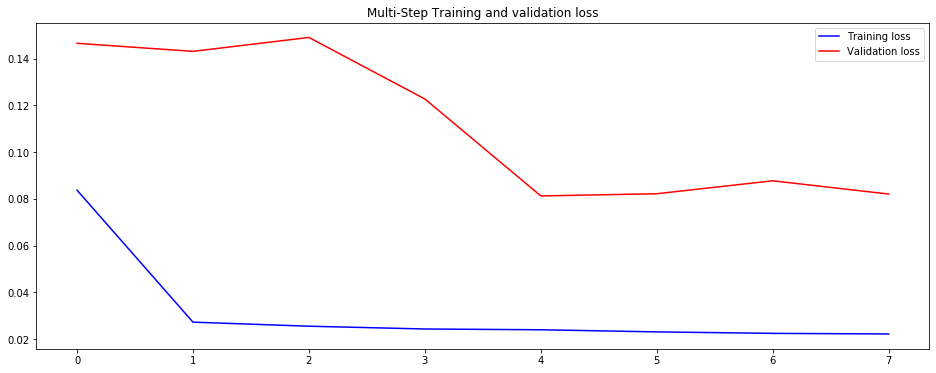

In [52]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

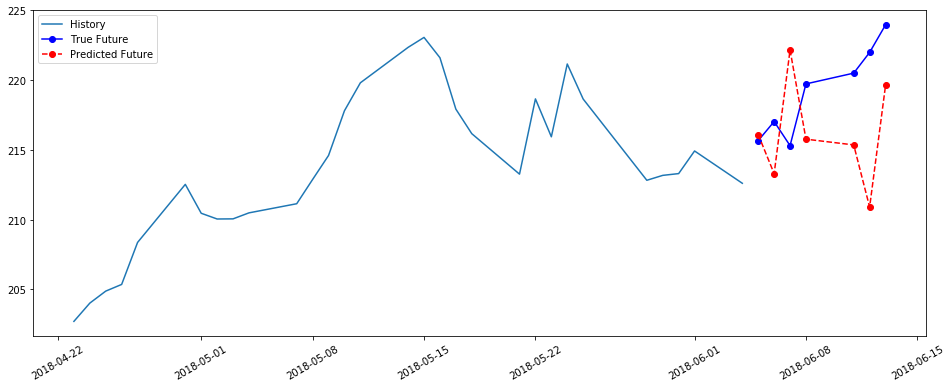

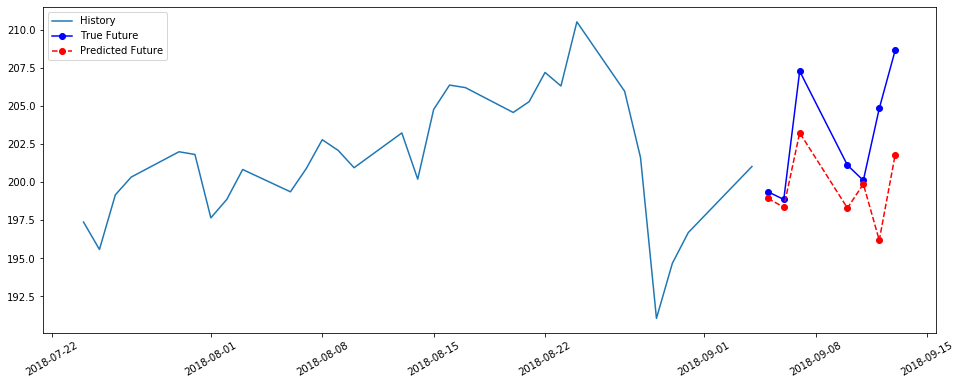

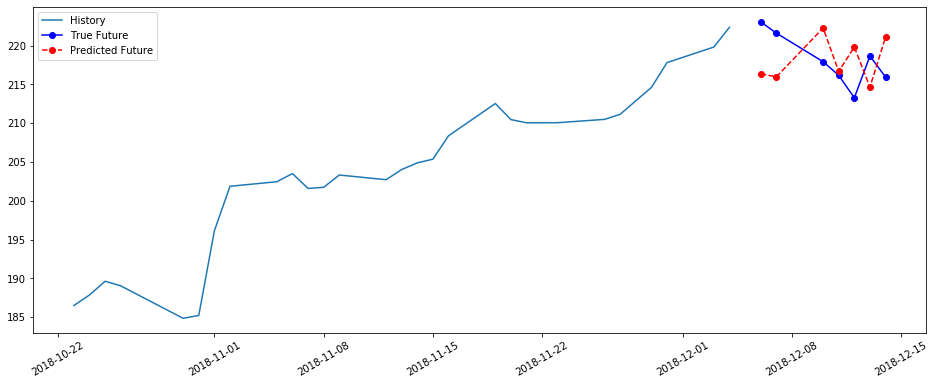

In [130]:
for xy, date in zip(val_data.take(3), val_dates.take(3)):
    
    x, y = xy
    x_dates, y_dates = date
#     print(x[0])
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = multi_step_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)

In [131]:
for xy, date in zip(test_data.take(2), test_dates.take(2)):
    
    x, y = xy
    x_dates, y_dates = date
#     print(x[0])
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    print([i for i in zip(true_future, y_dates[0].numpy())])
    prediction = multi_step_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)

ValueError: not enough values to unpack (expected 2, got 1)

In [47]:
df.tail()

,open,high,low,close,adjclose,volume,ticker
2020-05-21,318.660004,320.890015,315.869995,316.850006,316.850006,25672200.0,AAPL
2020-05-22,315.769989,319.230011,315.350006,318.890015,318.890015,20450800.0,AAPL
2020-05-26,323.500000,324.239990,316.500000,316.730011,316.730011,31380500.0,AAPL
2020-05-27,316.140015,318.709991,313.089996,318.109985,318.109985,28236300.0,AAPL
2020-05-28,316.769989,323.440002,315.630005,318.250000,318.250000,33390200.0,AAPL


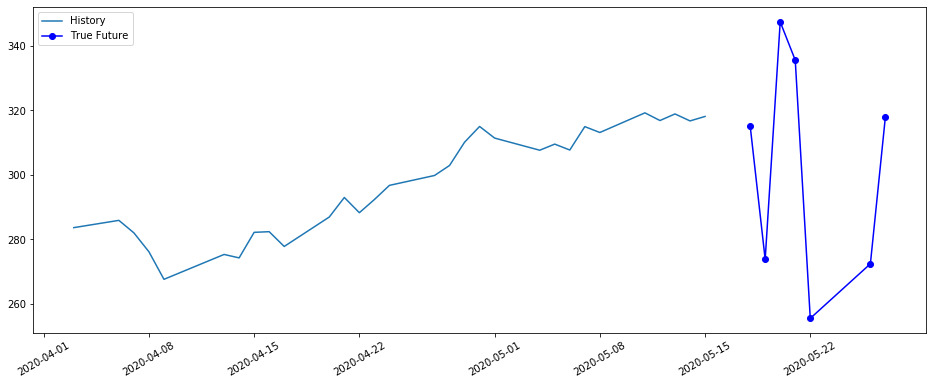

In [132]:
for x, date in zip(test_data.take(1), test_dates.take(1)):
    
    x = xy
    x_dates, y_dates = date
#     print(x[0])
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
#     true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = multi_step_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(),
                          prediction_rescaled)

In [107]:
pd.DatetimeIndex(dates)

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2020-05-14', '2020-05-15', '2020-05-18', '2020-05-19',
               '2020-05-20', '2020-05-21', '2020-05-22', '2020-05-26',
               '2020-05-27', '2020-05-28'],
              dtype='datetime64[ns]', length=2114, freq=None)

In [124]:
pd.DatetimeIndex([i.decode("utf-8") for i in x_dates[0].numpy().flatten()])

DatetimeIndex(['2020-04-03', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-17', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-27',
               '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01',
               '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
               '2020-05-08', '2020-05-11', '2020-05-12', '2020-05-13',
               '2020-05-14', '2020-05-15'],
              dtype='datetime64[ns]', freq=None)

In [111]:
pd.DatetimeIndex(x_dates[0].numpy().flatten())

TypeError: <class 'bytes'> is not convertible to datetime